In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
import os
import json
import numpy as np
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
val_images = 'model_data/instances_val2017_person.json'
img_path = "/home/public/datasets/coco/val2017"

In [5]:
# initialize COCO api for instance annotations
coco=COCO(val_images)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
COCO categories: 
person

COCO supercategories: 
person


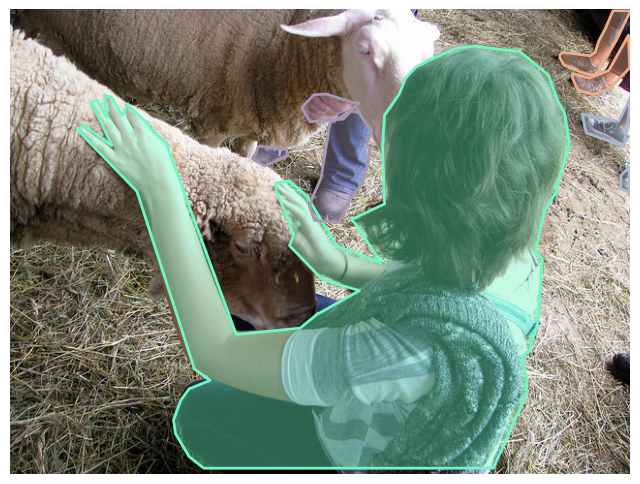

In [9]:
for imgId in imgIds[:2]:
    # Load the image 
    imgIds = coco.getImgIds(imgIds = [imgId])
    img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
    I = cv2.imread(os.path.join(img_path,img['file_name']))
    # Change I to RGB
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    plt.imshow(I); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    plt.show()

logs/resnet50/best_epoch_weights.pth model, and classes loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path |     logs/resnet50/best_epoch_weights.pth|
|             classes_path |            model_data/person_classes.txt|
|              input_shape |                               [544, 544]|
|               confidence |                                      0.5|
|                  nms_iou |                                      0.3|
|             anchors_size |                   [24, 48, 96, 192, 384]|
|          traditional_nms |                                    False|
|                     cuda |                                     True|
|              class_names |                               ['person']|
|              num_classes |                                        

TypeError: Invalid shape (1330, 1330, 7) for image data

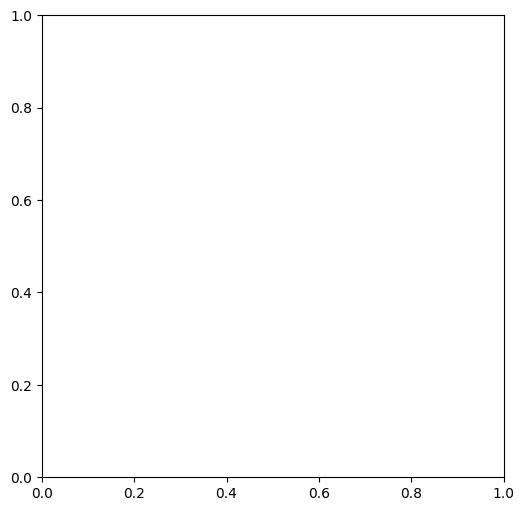

In [2]:
import colorsys
import os
import time

import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

# from nets.old_yolact import Yolact

from nets.yolact import Yolact


from utils.anchors import get_anchors
from utils.utils import (cvtColor, get_classes, preprocess_input, resize_image,
                         show_config)
from utils.utils_bbox import BBoxUtility

from collections import OrderedDict
#--------------------------------------------#
#   使用自己训练好的模型预测需要修改2个参数
#   model_path和classes_path都需要修改！
#--------------------------------------------#
class YOLACT(object):
    _defaults = {
        #--------------------------------------------------------------------------#
        #   使用自己训练好的模型进行预测一定要修改model_path和classes_path！
        #   model_path指向logs文件夹下的权值文件，classes_path指向model_data下的txt
        #
        #   训练好后logs文件夹下存在多个权值文件，选择验证集损失较低的即可。
        #   验证集损失较低不代表mAP较高，仅代表该权值在验证集上泛化性能较好。
        #   如果出现shape不匹配，同时要注意训练时的model_path和classes_path参数的修改
        #--------------------------------------------------------------------------#
        "model_path"        : 'logs/resnet50/best_epoch_weights.pth',
        "classes_path"      : 'model_data/person_classes.txt',
        #---------------------------------------------------------------------#
        #   输入图片的大小
        #---------------------------------------------------------------------#
        "input_shape"       : [544, 544],
        #---------------------------------------------------------------------#
        #   只有得分大于置信度的预测框会被保留下来
        #---------------------------------------------------------------------#
        "confidence"        : 0.5,
        #---------------------------------------------------------------------#
        #   非极大抑制所用到的nms_iou大小
        #---------------------------------------------------------------------#
        "nms_iou"           : 0.3,
        #---------------------------------------------------------------------#
        #   先验框的大小
        #---------------------------------------------------------------------#
        "anchors_size"      : [24, 48, 96, 192, 384],
        #---------------------------------------------------------------------#
        #   传统非极大抑制
        #---------------------------------------------------------------------#
        "traditional_nms"   : False,
        #-------------------------------#
        #   是否使用Cuda
        #   没有GPU可以设置成False
        #-------------------------------#
        "cuda"              : True
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    #---------------------------------------------------#
    #   初始化Yolact
    #---------------------------------------------------#
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        for name, value in kwargs.items():
            setattr(self, name, value)
        #---------------------------------------------------#
        #   计算总的类的数量
        #---------------------------------------------------#
        self.class_names, self.num_classes  = get_classes(self.classes_path)
        self.num_classes                    += 1
        self.anchors                        = torch.from_numpy(get_anchors(self.input_shape, self.anchors_size)).type(torch.FloatTensor)
        if self.cuda:
            self.anchors = self.anchors.cuda()
        
        #---------------------------------------------------#
        #   画框设置不同的颜色
        #---------------------------------------------------#
        if self.num_classes <= 81:
            self.colors = np.array([[0, 0, 0], [244, 67, 54], [233, 30, 99], [156, 39, 176], [103, 58, 183], 
                                    [100, 30, 60], [63, 81, 181], [33, 150, 243], [3, 169, 244], [0, 188, 212], 
                                    [20, 55, 200], [0, 150, 136], [76, 175, 80], [139, 195, 74], [205, 220, 57], 
                                    [70, 25, 100], [255, 235, 59], [255, 193, 7], [255, 152, 0], [255, 87, 34], 
                                    [90, 155, 50], [121, 85, 72], [158, 158, 158], [96, 125, 139], [15, 67, 34], 
                                    [98, 55, 20], [21, 82, 172], [58, 128, 255], [196, 125, 39], [75, 27, 134], 
                                    [90, 125, 120], [121, 82, 7], [158, 58, 8], [96, 25, 9], [115, 7, 234], 
                                    [8, 155, 220], [221, 25, 72], [188, 58, 158], [56, 175, 19], [215, 67, 64], 
                                    [198, 75, 20], [62, 185, 22], [108, 70, 58], [160, 225, 39], [95, 60, 144], 
                                    [78, 155, 120], [101, 25, 142], [48, 198, 28], [96, 225, 200], [150, 167, 134], 
                                    [18, 185, 90], [21, 145, 172], [98, 68, 78], [196, 105, 19], [215, 67, 84], 
                                    [130, 115, 170], [255, 0, 255], [255, 255, 0], [196, 185, 10], [95, 167, 234], 
                                    [18, 25, 190], [0, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], 
                                    [155, 0, 0], [0, 155, 0], [0, 0, 155], [46, 22, 130], [255, 0, 155], 
                                    [155, 0, 255], [255, 155, 0], [155, 255, 0], [0, 155, 255], [0, 255, 155], 
                                    [18, 5, 40], [120, 120, 255], [255, 58, 30], [60, 45, 60], [75, 27, 244], [128, 25, 70]], dtype='uint8')
        else:
            hsv_tuples = [(x / self.num_classes, 1., 1.) for x in range(self.num_classes)]
            self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
            self.colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), self.colors))

        self.bbox_util = BBoxUtility()
        self.generate()
        
        show_config(**self.__dict__)
        # TODO Add in a more clear show_config function

    #---------------------------------------------------#
    #   获得所有的分类
    #---------------------------------------------------#
    def generate(self, onnx=False):
        self.net    = Yolact(self.num_classes, train_mode=False)
        device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.net.load_state_dict(torch.load(self.model_path, map_location=device))

        self.net    = self.net.eval()
        print('{} model, and classes loaded.'.format(self.model_path))
        
        if not onnx:
            if self.cuda:
                self.net = nn.DataParallel(self.net)
                self.net = self.net.cuda()

    #---------------------------------------------------#
    #   检测图片
    #---------------------------------------------------#
    def detect_image(self, image):
        image_shape     = np.array(np.shape(image)[0:2])
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image           = cvtColor(image)
        image_origin    = np.array(image, np.uint8)
        #---------------------------------------------------------#
        #   直接resize到指定大小
        #---------------------------------------------------------#
        image_data      = resize_image(image, (self.input_shape[1], self.input_shape[0]))
        #---------------------------------------------------------#
        #   添加上batch_size维度，图片预处理，归一化。
        #---------------------------------------------------------#
        image_data      = np.expand_dims(np.transpose(preprocess_input(np.array(image_data, np.float32)), (2, 0, 1)), 0)

        with torch.no_grad():
            image_data = torch.from_numpy(image_data).type(torch.FloatTensor)
            if self.cuda:
                image_data = image_data.cuda()
            #---------------------------------------------------------#
            #   将图像输入网络当中进行预测！
            #---------------------------------------------------------#
            outputs = self.net(image_data)
            #---------------------------------------------------------#
            #   解码并进行非极大抑制
            #---------------------------------------------------------#
            results = self.bbox_util.decode_nms(outputs, self.anchors, self.confidence, self.nms_iou, image_shape, self.traditional_nms)

            if results[0] is None:
                return image
            box_thre, class_thre, class_ids, masks_arg, masks_sigmoid = [x.cpu().numpy() for x in results]
            
        #----------------------------------------------------------------------#
        #   masks_class [image_shape[0], image_shape[1]]
        #   根据每个像素点所属的实例和是否满足门限需求，判断每个像素点的种类
        #----------------------------------------------------------------------#
        masks_class     = masks_sigmoid * (class_ids[None, None, :] + 1) 
        masks_class     = np.reshape(masks_class, [-1, np.shape(masks_sigmoid)[-1]])
        masks_class     = np.reshape(masks_class[np.arange(np.shape(masks_class)[0]), np.reshape(masks_arg, [-1])], [image_shape[0], image_shape[1]])
        
        #---------------------------------------------------------#
        #   设置字体与边框厚度
        #---------------------------------------------------------#
        scale       = 0.6
        thickness   = int(max((image.size[0] + image.size[1]) // np.mean(self.input_shape), 1))
        font        = cv2.FONT_HERSHEY_DUPLEX
        color_masks     = self.colors[masks_class].astype('uint8')
        image_fused     = cv2.addWeighted(color_masks, 0.4, image_origin, 0.6, gamma=0)
        for i in range(np.shape(class_ids)[0]):
            left, top, right, bottom = np.array(box_thre[i, :], np.int32)

            #---------------------------------------------------------#
            #   获取颜色并绘制预测框
            #---------------------------------------------------------#
            color = self.colors[class_ids[i] + 1].tolist()
            cv2.rectangle(image_fused, (left, top), (right, bottom), color, thickness)

            #---------------------------------------------------------#
            #   获得这个框的种类并写在图片上
            #---------------------------------------------------------#
            class_name  = self.class_names[class_ids[i]]
            text_str    = f'{class_name}: {class_thre[i]:.2f}'
            text_w, text_h = cv2.getTextSize(text_str, font, scale, 1)[0]
            cv2.rectangle(image_fused, (left, top), (left + text_w, top + text_h + 5), color, -1)
            cv2.putText(image_fused, text_str, (left, top + 15), font, scale, (255, 255, 255), 1, cv2.LINE_AA)

        image = Image.fromarray(np.uint8(image_fused))
        return image

    def get_FPS(self, image, test_interval):
        image_shape     = np.array(np.shape(image)[0:2])
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image           = cvtColor(image)
        #---------------------------------------------------------#
        #   直接resize到指定大小
        #---------------------------------------------------------#
        image_data      = resize_image(image, (self.input_shape[1], self.input_shape[0]))
        #---------------------------------------------------------#
        #   添加上batch_size维度，图片预处理，归一化。
        #---------------------------------------------------------#
        image_data      = np.expand_dims(np.transpose(preprocess_input(np.array(image_data, np.float32)), (2, 0, 1)), 0)

        with torch.no_grad():
            image_data = torch.from_numpy(image_data).type(torch.FloatTensor)
            if self.cuda:
                image_data = image_data.cuda()
            #---------------------------------------------------------#
            #   将图像输入网络当中进行预测！
            #---------------------------------------------------------#
            outputs = self.net(image_data)
            #---------------------------------------------------------#
            #   解码并进行非极大抑制
            #---------------------------------------------------------#
            results = self.bbox_util.decode_nms(outputs, self.anchors, self.confidence, self.nms_iou, image_shape, self.traditional_nms)

        t1 = time.time()
        for _ in range(test_interval):
            with torch.no_grad():
                #---------------------------------------------------------#
                #   将图像输入网络当中进行预测！
                #---------------------------------------------------------#
                outputs = self.net(image_data)
                #---------------------------------------------------------#
                #   解码并进行非极大抑制
                #---------------------------------------------------------#
                results = self.bbox_util.decode_nms(outputs, self.anchors, self.confidence, self.nms_iou, image_shape, self.traditional_nms)
        t2 = time.time()
        tact_time = (t2 - t1) / test_interval
        return tact_time

    def convert_to_onnx(self, simplify, model_path):
        import onnx
        self.generate(onnx=True)

        im                  = torch.zeros(1, 3, *self.input_shape).to('cpu')  # image size(1, 3, 512, 512) BCHW
        input_layer_names   = ["images"]
        output_layer_names  = ["output"]
        
        # Export the model
        print(f'Starting export with onnx {onnx.__version__}.')
        torch.onnx.export(self.net,
                        im,
                        f               = model_path,
                        verbose         = False,
                        opset_version   = 12,
                        training        = torch.onnx.TrainingMode.EVAL,
                        do_constant_folding = True,
                        input_names     = input_layer_names,
                        output_names    = output_layer_names,
                        dynamic_axes    = None)

        # Checks
        model_onnx = onnx.load(model_path)  # load onnx model
        onnx.checker.check_model(model_onnx)  # check onnx model

        # Simplify onnx
        if simplify:
            import onnxsim
            print(f'Simplifying with onnx-simplifier {onnxsim.__version__}.')
            model_onnx, check = onnxsim.simplify(
                model_onnx,
                dynamic_input_shape=False,
                input_shapes=None)
            assert check, 'assert check failed'
            onnx.save(model_onnx, model_path)

        print('Onnx model save as {}'.format(model_path))

    def get_map_out(self, image):
        image_shape     = np.array(np.shape(image)[0:2])
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image           = cvtColor(image)
        #---------------------------------------------------------#
        #   直接resize到指定大小
        #---------------------------------------------------------#
        image_data      = resize_image(image, (self.input_shape[1], self.input_shape[0]))
        #---------------------------------------------------------#
        #   添加上batch_size维度，图片预处理，归一化。
        #---------------------------------------------------------#
        image_data      = np.expand_dims(np.transpose(preprocess_input(np.array(image_data, np.float32)), (2, 0, 1)), 0)

        with torch.no_grad():
            image_data = torch.from_numpy(image_data).type(torch.FloatTensor)
            if self.cuda:
                image_data = image_data.cuda()
            #---------------------------------------------------------#
            #   将图像输入网络当中进行预测！
            #---------------------------------------------------------#
            outputs = self.net(image_data)
            #---------------------------------------------------------#
            #   解码并进行非极大抑制
            #---------------------------------------------------------#
            results = self.bbox_util.decode_nms(outputs, self.anchors, self.confidence, self.nms_iou, image_shape, self.traditional_nms)

            if results[0] is None:
                return None, None, None, None, None
            box_thre, class_thre, class_ids, masks_arg, masks_sigmoid = [x.cpu().numpy() for x in results]

        return box_thre, class_thre, class_ids, masks_arg, masks_sigmoid

    def get_single_image(self, img):
        """
        This function takes a PIL image as input, performs object detection on it,
        and returns the detected objects, their bounding boxes, classes, and masks.

        Args:
            img (PIL.Image): The input image.

        Returns:
            dict: A dictionary containing the following fields:
                'boxes': A list of bounding boxes of detected objects. Each bounding box is represented by a list of four integers.
                'classes': A list of class IDs of detected objects.
                'scores': A list of confidence scores of detected objects.
                'masks': A list of binary masks of detected objects. Each mask is a 2D numpy array.
        """
        image_shape     = np.array(np.shape(img)[0:2])
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image           = cvtColor(img)
        image_origin    = np.array(image, np.uint8)
        #---------------------------------------------------------#
        #   直接resize到指定大小
        #---------------------------------------------------------#
        image_data      = resize_image(image, (self.input_shape[1], self.input_shape[0]))
        #---------------------------------------------------------#
        #   添加上batch_size维度，图片预处理，归一化。
        #---------------------------------------------------------#
        image_data      = np.expand_dims(np.transpose(preprocess_input(np.array(image_data, np.float32)), (2, 0, 1)), 0)

        with torch.no_grad():
            image_data = torch.from_numpy(image_data).type(torch.FloatTensor)
            if self.cuda:
                image_data = image_data.cuda()
            #---------------------------------------------------------#
            #   将图像输入网络当中进行预测！
            #---------------------------------------------------------#
            outputs = self.net(image_data)
            #---------------------------------------------------------#
            #   解码并进行非极大抑制
            #---------------------------------------------------------#
            results = self.bbox_util.decode_nms(outputs, self.anchors, self.confidence, self.nms_iou, image_shape, self.traditional_nms)

            if results[0] is None:
                return image
            box_thre, class_thre, class_ids, masks_arg, masks_sigmoid = [x.cpu().numpy() for x in results]

        masks_class     = masks_sigmoid * (class_ids[None, None, :] + 1) 
        # masks_class     = np.reshape(masks_class, [-1, np.shape(masks_sigmoid)[-1]])
        # masks_class     = np.reshape(masks_class[np.arange(np.shape(masks_class)[0]), np.reshape(masks_arg, [-1])], [image_shape[0], image_shape[1]])
        # color_masks     = self.colors[masks_class].astype('uint8')
        # 相当于是二分类，只有0和1
        
        # Prepare the result
        result = {
            'boxes': box_thre.tolist(),
            'classes': class_ids.tolist(),
            'scores': class_thre.tolist(),
            'masks': masks_class.tolist()
        }
        return result


    

if __name__ == "__main__":
    yolact = YOLACT()
    img = Image.open('img/street.jpg')  # replace 'test.jpg' with your image path
    result = yolact.get_single_image(img)
    # print(result)

    # Print the results seperately
    print('Boxes shape:')
    print(np.array(result['boxes']).shape)
    print(result['boxes'])

    print('Classes shape:')
    print(np.array(result['classes']).shape)
    print(result['classes'])

    print('Scores shape:')
    print(np.array(result['scores']).shape)
    print(result['scores'])


    print('Masks shape:')
    print(np.array(result['masks']).shape)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    
    plt.imshow(result['masks'])
    plt.show()

    
    # 现在有一个 mask 【540，540，3】， 我希望对里面的点进行滤波，使得最终出来的mask是平滑的

TypeError: Invalid shape (1330, 1330, 7) for image data

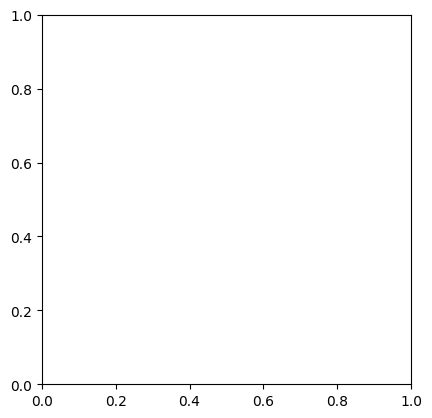

In [4]:
plt.imshow(result['masks'])

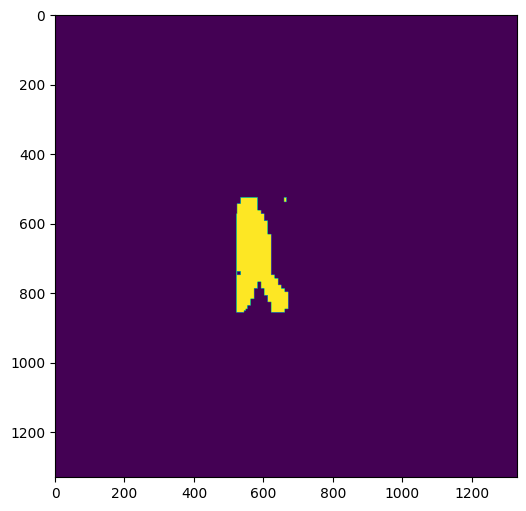

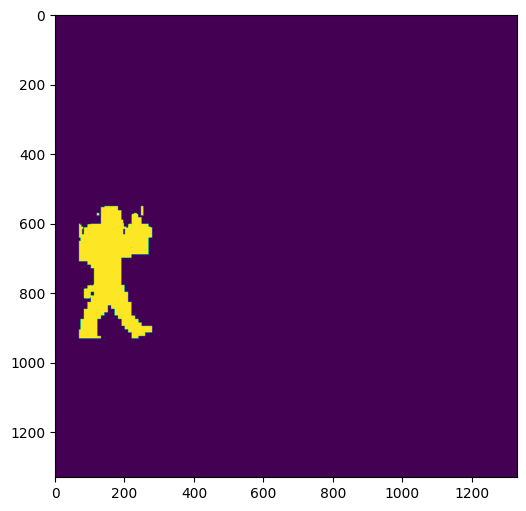

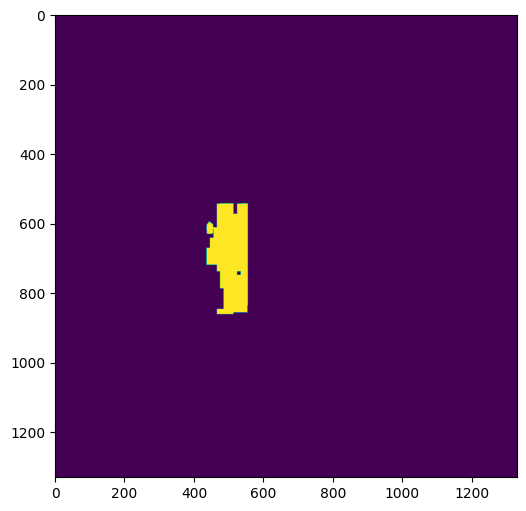

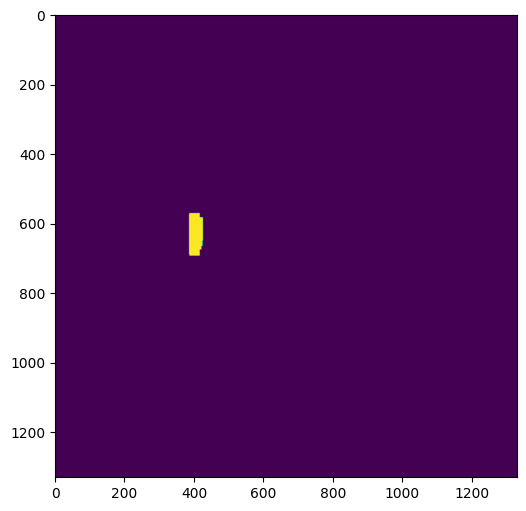

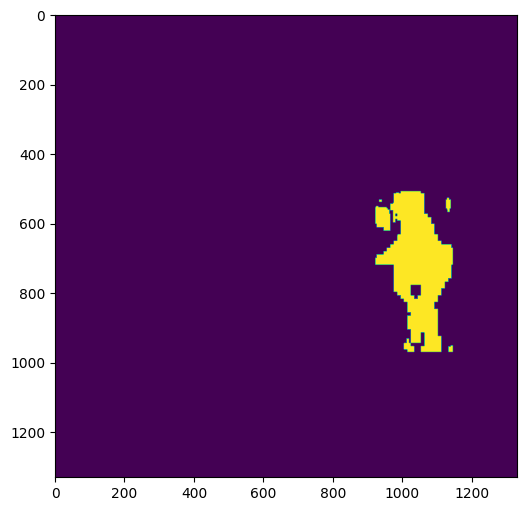

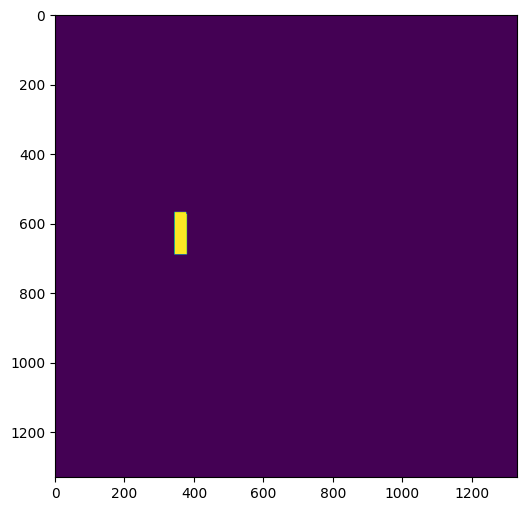

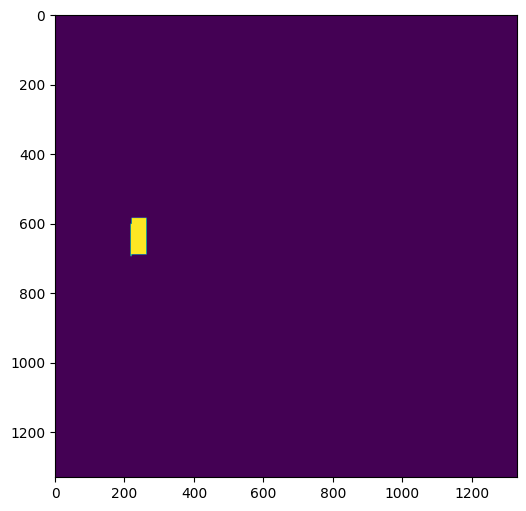

In [6]:
result['masks'] = np.array(result['masks'])
# Permute the mask to [H, W, C]
result['masks'] = np.transpose(result['masks'], (2, 0, 1))    
for item in result['masks']:
    plt.figure(figsize=(8, 6))
    plt.imshow(item)
    plt.show()